In [7]:
import numpy as np
from scipy.integrate import quad

# TESTING i(m - m Cos[m Pi] Cos[n Pi] - n Sin[m Pi] Sin[n Pi])/(m^2 Pi - n^2 Pi)
# (-n + n cos(m π) cos(n π) + m sin(m π) sin(n π))/(m^2 π - n^2 π)
def test_weird_trig(n, m):
    """
    """
    pi = np.pi

    def gr1(t):
        return np.cos(n * pi * t) * np.sin(m * pi * t)

    int1, _ = quad(gr1, 0, 1, limit = 500)

    # formula (-n sin(π m) sin(π n) + m (-cos(π m)) cos(π n) + m)/(π m^2 - π n^2)

    if n != m:
        int_chk = (m - m * np.cos(m * pi) * np.cos(n * pi) - m * np.sin(m * pi) * np.sin(n * pi))/(pi * (m**2 - n**2))
    else:
        int_chk = 0

    dev = np.abs(int1 - int_chk)
    # print(n. m)
    print("deviation: ", dev, n, m)

test_weird_trig(2,5)

deviation:  1.3877787807814457e-16 2 5


In [8]:
import numpy as np
from scipy.integrate import quad


def fourier_integral_cost_fn(a_coeffs, b_coeffs, kappa, lambd):
    """
    Compute the integral I = ∫₀¹ [ (a_dot + λ b_dot) a_dot + kappa (a + λ b) a_dot ] dt

    where each of a, b, a_dot, b_dot is formed using the coefficients passed in:

    a(t) = t + sum a_n sin(n pi t)
    b(t) = t + sum b_n sin(n pi t)
    a_dot(t) = 1 + sum a_n n pi cos(n pi t)
    b_dot(t) = 1 + sum b_n n pi cos(n pi t)

    Integral components:

    Int_IV: \int_0^1 

    Purpose:

    Allows us to check if integrating the loss function formed from the Fourier approximations of
    the strategies and their derivatives yields the same result as integrating the loss function
    itself.
    
    Parameters:
    a_coeffs (list or array): Coefficients aₙ for n = 1 to N
    b_coeffs (list or array): Coefficients bₙ for n = 1 to N
    lambd (float): Constant λ
    kappa (float): Constant κ (not used in this integral but included as per the request)
    
    Returns:
    float: The computed value of the integral I
    """
    # Ensure coefficients are numpy arrays
    a_coeffs = np.array(a_coeffs, dtype=np.float64)
    b_coeffs = np.array(b_coeffs, dtype=np.float64)
    N = len(a_coeffs)
    
    if len(b_coeffs) != N:
        raise ValueError("Sequences a_coeffs and b_coeffs must be of the same length.")
    
    pi = np.pi

    # Define the functions a(t), b(t), a_dot(t), b_dot(t)
    def a(t):
        n = np.arange(1, N+1)  # 1-based indexing
        terms = a_coeffs * np.sin(n * pi * t)
        return t + np.sum(terms)
    
    def b(t):
        n = np.arange(1, N+1)
        terms = b_coeffs * np.sin(n * pi * t)
        return t + np.sum(terms)
    
    def a_dot(t):
        n = np.arange(1, N+1)
        terms = a_coeffs * n * pi * np.cos(n * pi * t)
        return 1 + np.sum(terms)
    
    def b_dot(t):
        n = np.arange(1, N+1)
        terms = b_coeffs * n * pi * np.cos(n * pi * t)
        return 1 + np.sum(terms)

    def a_b_dot(t):
        n = np.arange(1, N+1)
        m = np.arange(1, N+1)
        terms_b = b_coeffs * np.sin(m * pi * t)
        terms_a_dot = a_coeffs * n * pi * np.cos(n * pi * t)
        return terms_b*terms_a_dot

    # Components of the loss function

    # a'(t) * a'(t) (temporary impact)
    def int_adot_adot(t):
        a_t = a(t)
        b_t = b(t)
        a_dot_t = a_dot(t)
        b_dot_t = b_dot(t)
        return a_dot_t * a_dot_t

    # lambda b'(t) * a'(t) (temporary impact)
    def int_adot_lam_bdot(t):
        a_dot_t = a_dot(t)
        b_dot_t = b_dot(t)
        return lambd * b_dot_t * a_dot_t

    def int_kappa_a_a_dot(t):
        a_t = a(t)
        b_t = b(t)
        a_dot_t = a_dot(t)
        b_dot_t = b_dot(t)
        return kappa * a_t * a_dot_t

    # kappa * lambda * b(t) * a'(t)
    def int_kappa_lambd_b_a_dot(t):
        b_t = b(t)
        a_dot_t = a_dot(t)
        return kappa * lambd * b_t * a_dot_t

    int_I, error = quad(int_adot_adot, 0, 1, limit=100)
    int_II, error = quad(int_adot_lam_bdot, 0, 1, limit=100)
    int_III, error = quad(int_kappa_a_a_dot, 0, 1, limit=100)
    int_IV, error = quad(int_kappa_lambd_b_a_dot, 0, 1, limit=100)

    # Dissection of integral IV into four components

    def t_fn(t):
        return lambd * kappa * t
        
    
    def int_IV_component2(t):
        b_t = b(t)
        return lambd * kappa * (b_t - t)

    int_IV_2, _ = quad(int_IV_component2, 0, 1, limit=100)

    def int_IV_component3(t):
        a_dot_t = a_dot(t)
        return lambd * kappa * t * (a_dot_t - 1) 

    def int_IV_component4(t):
        a_dot_t = a_dot(t)
        b_t = b(t)
        return lambd * kappa * (a_dot_t - 1) * (b_t - t)

    int_IV_1, _ = quad(t_fn, 0, 1, limit=100)
    int_IV_2, _ = quad(int_IV_component2, 0, 1, limit=100)    
    int_IV_3, _ = quad(int_IV_component3, 0, 1, limit=100)
    int_IV_4, _ = quad(int_IV_component4, 0, 1, limit=100)

    integral = int_I + int_II + int_III + int_IV

    print("FOURIER INTEGRAL VALUES")
    print("int_I (int_0^1 a'(t) * a'(t) dt): ", int_I)
    print("int_II: (int_0^1 lambda a'(t) * b'(t) dt): ", int_II)
    print("int_III: (int_0^1 kappa a(t) * a'(t) dt): ", int_III)
    print("int_IV: (int_0^1 kappa * lambda * b(t) * a'(t) dt): ", int_IV)
    print("\tint_0^1 lambda kappa t dt: ", int_IV_1)
    print("\tint_0^1 lambda kappa b(t) dt: ", int_IV_2)
    print("\tint_0^1 lambda kappa t * a'(t) dt: ", int_IV_3)
    print("\tint_0^1 lambda kappa (a'(t)-1)(b(t)-t) dt: ", int_IV_4)
    print("\tTotal of components: ", int_IV_1 + int_IV_2 + int_IV_3 + int_IV_4)
    print("Integral of the loss function computed from Fourier approximations:", integral)
    
    return integral



<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
C:\Users\vragu\AppData\Local\Temp\ipykernel_31644\2230738571.py:6: SyntaxWarning: invalid escape sequence '\i'
  """


In [9]:
# Exact cost computation function
def compute_integral_loss_function_direct(a_func, b_func, a_func_dot, b_func_dot, kappa, lambd):
    """
    This computes the intgral of the loss function directly by integrating the 
    functions of the trading strategies and their derivatives.

    WARNING: the derivatives of the functions are not checked for correctness.|
    """
    
    # I: \int_0^1 \dot{a} \dot{a} dt 
    def integrand_I(t):
        a_dot = a_func_dot(t, kappa, lambd)
        return a_dot * a_dot 
    
    # II: \int_0^1 lambda \dot{b} \dot{a} dt 
    def integrand_II(t):
        a_dot = a_func_dot(t, kappa, lambd)
        b_dot = b_func_dot(t, kappa, lambd)
        return lambd * b_dot * a_dot 
    
    # III: \int_0^1 kappa a \dot{a} dt
    def integrand_III(t):
        a_dot = a_func_dot(t, kappa, lambd)
        return kappa * a_func(t, kappa, lambd) * a_dot
        
    # IV: \int_0^1 kappa lambda b \dot{a} dt
    def integrand_IV(t):
        a_dot = a_func_dot(t, kappa, lambd)
        return kappa *  lambd * b_func(t, kappa, lambd) * a_dot
    
    int_I, _ = quad(integrand_I, 0, 1)
    int_II, _ = quad(integrand_II, 0, 1)
    int_III, _ = quad(integrand_III, 0, 1)
    int_IV, _ = quad(integrand_IV, 0, 1)

    integral = int_I + int_II + int_III + int_IV

    # Dissection of integral IV into four components

    def t_fn(t):
        return lambd * kappa * t
        
    def int_IV_component2(t):
        b_t = b_func(t, kappa, lambd)
        return lambd * kappa * (b_t - t)
        
    def int_IV_component3(t):
        a_dot_t = a_func_dot(t, kappa, lambd)
        return lambd * kappa * t * (a_dot_t - 1) 

    #  return lambd * kappa * (a_dot_t - 1) * (b_t - 1)
    def int_IV_component4(t):
        a_dot_t = a_func_dot(t, kappa, lambd)
        b_t = b_func(t, kappa, lambd)
        return lambd * kappa * (b_t - t)*(a_dot_t - 1)

    int_IV_1, _ = quad(t_fn, 0, 1, limit=100)
    int_IV_2, _ = quad(int_IV_component2, 0, 1, limit=100)
    int_IV_3, _ = quad(int_IV_component3, 0, 1, limit=100)
    int_IV_4, _ = quad(int_IV_component4, 0, 1, limit=100)

    print("INTEGRATION OF LOSS FUNCTION FROM ORIGINAL FUNCTIONS")
    print("int_I: ", int_I)
    print("int_II: ", int_II)    
    print("int_III: ", int_III)
    print("int_IV: ", int_IV)
    print("\tint_0^1 lambda kappa t dt: ", int_IV_1)
    print("\tint_0^1 lambda kappa (b(t)-t) dt: ", int_IV_2)
    print("\tint_0^1 lambda kappa t * (a'(t)-1) dt: ", int_IV_3)
    print("\tint_0^1 lambda kappa (b(t) - 1)*(a'(t) - 1) dt: ", int_IV_4)
    print("\tTotal of components: ", int_IV_1 + int_IV_2 + int_IV_3 + int_IV_4)

    print("Exact integral of loss function: ", integral)
    
    return integral


In [10]:
import numpy as np

# integral of cos(n pi t) sin(n pi t) in closed form
def int_cos_sin(n, m):
    pi = np.pi
    if n != m:
        int_chk = (m - m * np.cos(m * pi) * np.cos(n * pi) - m * np.sin(m * pi) * np.sin(n * pi))/(pi * (m**2 - n**2))
    else:
        int_chk = 0

    return int_chk

def approx_cost_fn_no_integral_formula(a_n, b_n, kappa, lambd):
    """
    This computes the cost function from the formula in the Real-world constraints paper.
    This approach avoids computing integrals.
    
    Parameters:
    a_n (array-like): Coefficients a_n for n from 1 to N
    b_n (array-like): Coefficients b_n for n from 1 to N
    kappa (float): Constant κ (kappa)
    lambd (float): Constant λ (lambda)
    
    Returns:
    float: The computed value of the expression I
    """
    # Ensure input sequences are numpy arrays
    a_n = np.array(a_n, dtype=np.float64)
    b_n = np.array(b_n, dtype=np.float64)
    N = len(a_n)

    if len(b_n) != N:
        raise ValueError("Sequences a_n and b_n must be of the same length.")
    
    n = np.arange(1, N + 1)  # n from 1 to N

    # Compute the third term: kappa * [ (1 + lambd) / 2 + sum_{n odd} (2 * (b_n - a_n)) / (n * π) ]
    odd_indices = np.where(n % 2 == 1)[0]  # Indices where n is odd
    n_odd = n[odd_indices]
    a_n_odd = a_n[odd_indices]
    b_n_odd = b_n[odd_indices]
    pi = np.pi

    
    # I: \int_0^1 \dot{a} \dot{a} dt 
    int_I = 1 + 0.5 * np.sum(n**2 * pi**2 * a_n**2)

    # II: \int_0^1 lambda \dot{b} \dot{a} dt 
    int_II = lambd + (lambd/2) * np.sum(n**2 * pi**2 * a_n * b_n)

    # III: \int_0^1 kappa \dot{a} a dt
    int_III = kappa/2
    
    ans = 0
    for n, a_co in enumerate(a_n, start=1):
        for m, b_co in enumerate(b_n, start=1):
           ans += a_co * b_co * n * pi * int_cos_sin(n, m)

    iv4 =  kappa * lambd * ans 
    
    
    int_IV_1 = kappa * lambd * 0.5
    int_IV_2 = ((2 * lambd * kappa)/pi) * np.sum(b_n_odd / n_odd)
    int_IV_3 = -((2 * lambd * kappa)/pi) * np.sum(a_n_odd / n_odd)
    int_IV_4 = iv4

    int_IV = int_IV_1 + int_IV_2 + int_IV_3 + int_IV_4
    integral = int_I + int_II + int_III + int_IV

    
    print("APPROX TOTAL COST FUNCTION FROM APPROX FORMULA:")
    print("int_I: ", int_I)
    print("int_II: ", int_II)
    print("int_III: ", int_III)
    print("int_IV: ", int_IV)
    print("\tint_0^1 lambda kappa t dt: ", int_IV_1)
    print("\tint_0^1 lambda kappa (b(t)-t) dt: ", int_IV_2)
    print("\tint_0^1 lambda kappa t * (a'(t)-1) dt: ", int_IV_3)
    print("\tint_0^1 lambda kappa (b(t) - 1)*(a'(t) - 1) dt: ", int_IV_4)
    print("\tTotal of components: ", int_IV_1 + int_IV_2 + int_IV_3 + int_IV_4)

    print("Loss function approximation formula: ", integral)

    return int_I + int_II + int_III + int_IV


In [11]:
import numpy as np
from scipy.integrate import quad

def compute_sine_series_for_functions(a_func, b_func, kappa, lambd, N):
    """
    Compute the sine series coefficients a_n and b_n for functions a_func and b_func.
    
    Parameters:
    a_func: function(t, lambd, kappa, N)
        The function a_func(t, lambd, kappa, N) to be expanded.
    b_func: function(t, lambd, kappa, N)
        The function b_func(t, lambd, kappa, N) to be expanded.
    lambd: float
        Parameter lambda.
    kappa: float
        Parameter kappa.
    N: int
        Number of terms in the series.
    
    Returns:
    a_coeffs: numpy array
        The sine series coefficients for a_func.
    b_coeffs: numpy array
        The sine series coefficients for b_func.
    """
    pi = np.pi
    a_coeffs = np.zeros(N)
    b_coeffs = np.zeros(N)
    
    for n in range(1, N+1):
        # Compute coefficients for a_func
        def integrand_a(t):
            return 2 * (a_func(t, kappa, lambd) - t) * np.sin(n * pi * t)
        coeff_a, _ = quad(integrand_a, 0, 1)
        a_coeffs[n-1] = coeff_a
        
        # Compute coefficients for b_func
        def integrand_b(t):
            return 2 * (b_func(t, kappa, kappa) - t) * np.sin(n * pi * t)
        coeff_b, _ = quad(integrand_b, 0, 1)
        b_coeffs[n-1] = coeff_b
        
    return a_coeffs, b_coeffs

In [12]:
# EXAMPLE functions to be used in calculations

# Example functions that satisfy f(0) = 0 and f(1) = 1
def a_func(t, kappa, lambd):
    # Example function depending on lambda and kappa
    # Satisfies boundary conditions f(0) = 0, f(1) = 1
    return t**2 + lambd * np.sin(np.pi * t)

# Derivative of a_func (WARNING: there is no check to see if this is it!)
def a_func_dot(t, kappa, lambd):
    return 2*t + np.pi * lambd * np.cos(np.pi * t)

def b_func(t, kappa, lambd):
    # Another example function depending on lambda and kappa
    # Satisfies boundary conditions f(0) = 0, f(1) = 1
    return t**3  + kappa * np.sin(2 * np.pi * t)

# Derivative of b_func (WARNING: there is no check to see if this is it!)
def b_func_dot(t, kappa, lambd):
    # Another example function depending on lambda and kappa
    # Satisfies boundary conditions f(0) = 0, f(1) = 1
    return 3*t**2 + 2 * np.pi * kappa * np.cos(2 * np.pi * t)

In [13]:
# TESTING THE FUNCTIONS
if __name__ == "__main__":
    # Example coefficients
    # a_coeffs = [1.0, -0.5, 0.25]  # Replace with your coefficients
    # b_coeffs = [0.5, 0.75, -0.3]  # Replace with your coefficients
    lambd = 1  # Replace with your value
    kappa = 1  # Replace with your value (not used in this integral)
    N = 5  # Number of terms in the series
    
    # Compute the sine series coefficients
    a_coeffs, b_coeffs = compute_sine_series_for_functions(a_func, b_func, kappa, lambd, N)
    
    I = fourier_integral_cost_fn(a_coeffs, b_coeffs, kappa, lambd)
    print("---> The value of the Fourier actual cost fn is:", I)
    print()

    I = compute_integral_loss_function_direct(a_func, b_func, a_func_dot, b_func_dot, kappa, lambd)
    print("---> The value of the exact integrated actual cost fn is:", I)
    print()

    I = approx_cost_fn_no_integral_formula(a_coeffs, b_coeffs, kappa, lambd)

    print("---> The value of the totally new approximate cost fn is:", I)
    print()

FOURIER INTEGRAL VALUES
int_I (int_0^1 a'(t) * a'(t) dt):  3.7214158582089008
int_II: (int_0^1 lambda a'(t) * b'(t) dt):  -0.41022019640092267
int_III: (int_0^1 kappa a(t) * a'(t) dt):  0.5000000000000001
int_IV: (int_0^1 kappa * lambda * b(t) * a'(t) dt):  0.845639704084641
	int_0^1 lambda kappa t dt:  0.5
	int_0^1 lambda kappa b(t) dt:  -0.24981956035091035
	int_0^1 lambda kappa t * a'(t) dt:  -0.47007339880030774
	int_0^1 lambda kappa (a'(t)-1)(b(t)-t) dt:  1.065532663235859
	Total of components:  0.845639704084641
Integral of the loss function computed from Fourier approximations: 4.6568353658926185
---> The value of the Fourier actual cost fn is: 4.6568353658926185

INTEGRATION OF LOSS FUNCTION FROM ORIGINAL FUNCTIONS
int_I:  3.7216564444076865
int_II:  -0.4098593171027439
int_III:  0.5
int_IV:  0.8471122017965644
	int_0^1 lambda kappa t dt:  0.5
	int_0^1 lambda kappa (b(t)-t) dt:  -0.25000000000000006
	int_0^1 lambda kappa t * (a'(t)-1) dt:  -0.46995310570091464
	int_0^1 lambda k

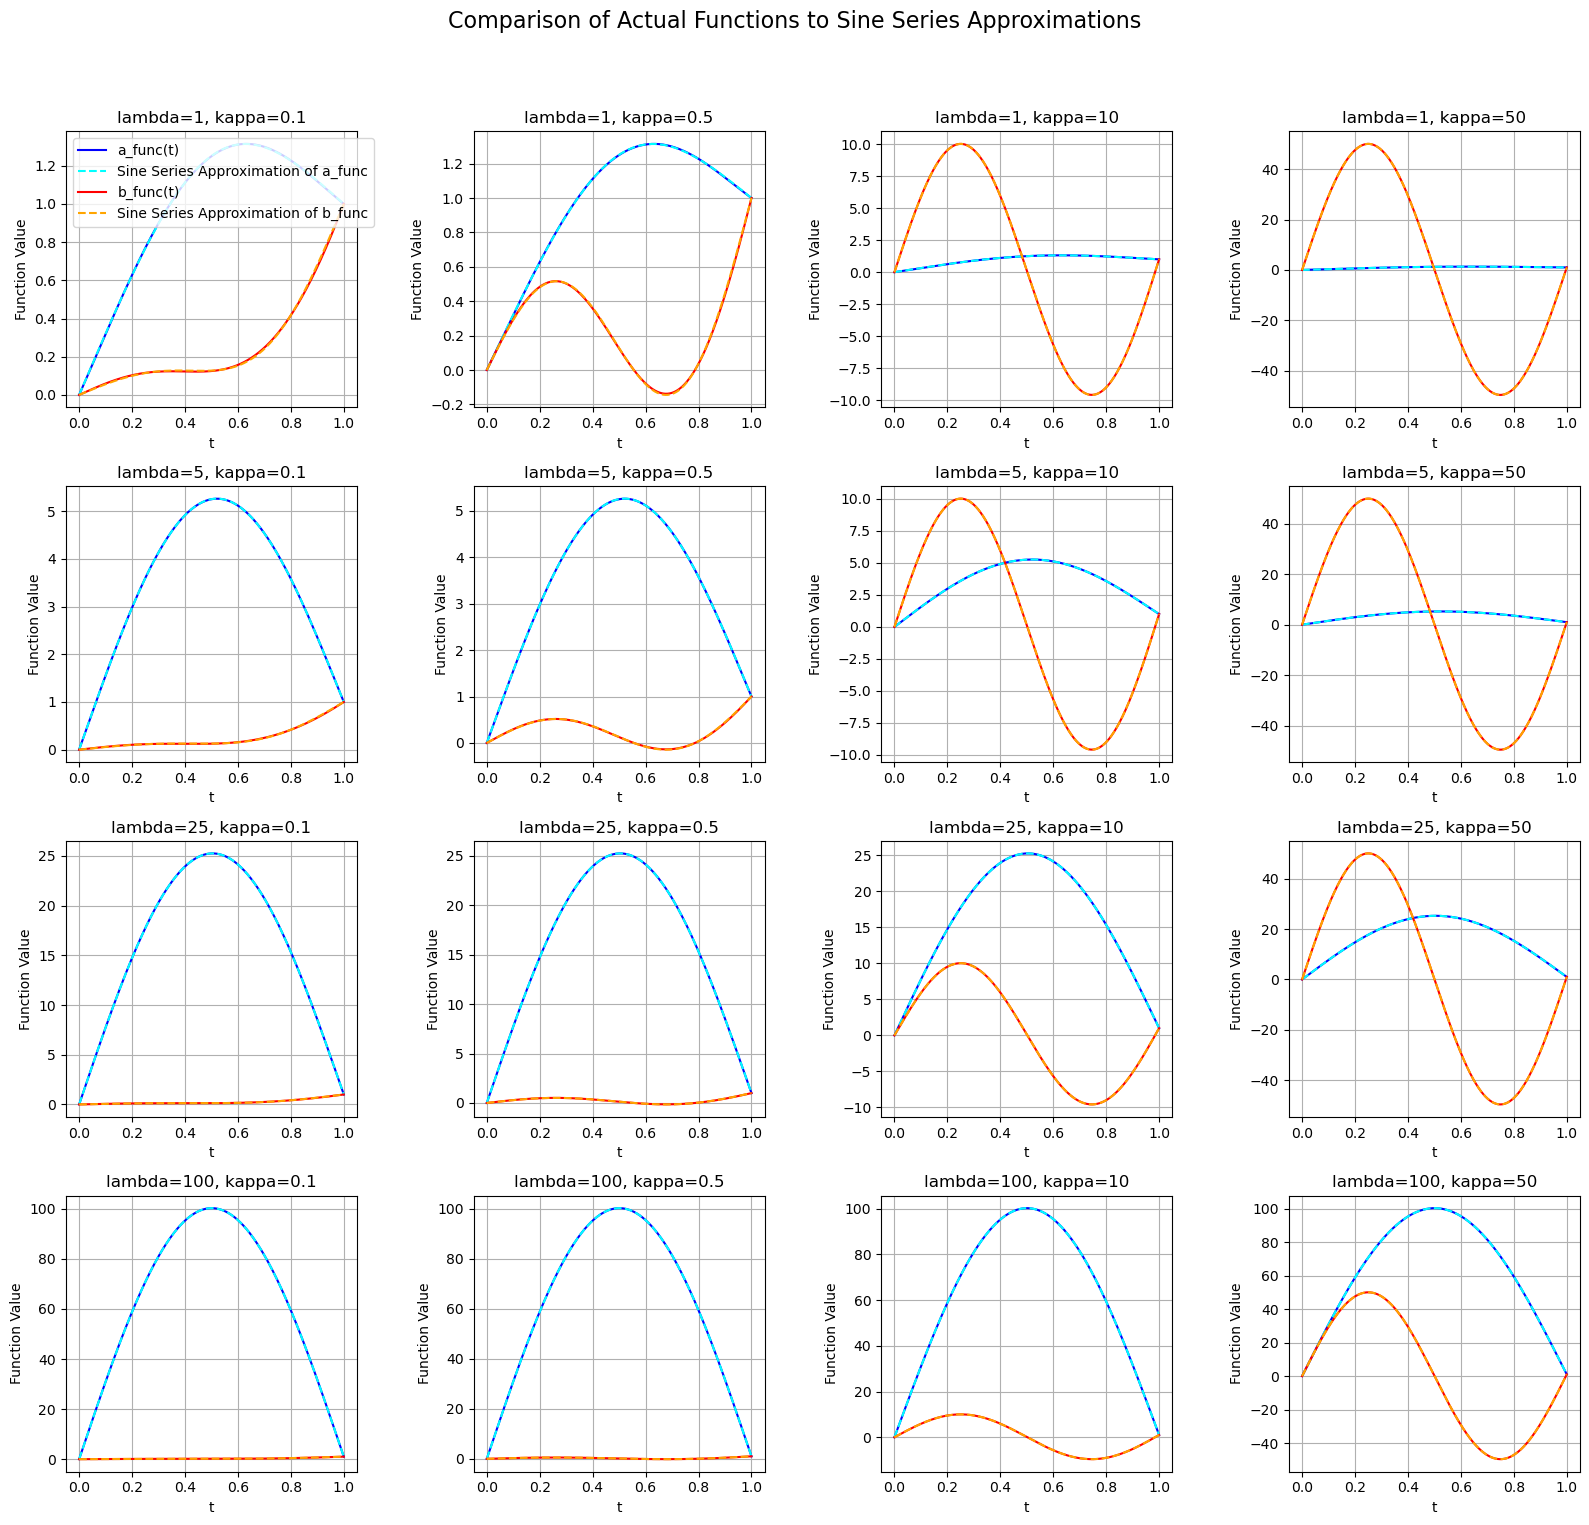

In [1230]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

def compute_sine_series_for_functions_2(a_func, b_func, kappa, lambd,  N):
    """
    Compute the sine series coefficients a_n and b_n for functions a_func and b_func.
    
    Parameters:
    a_func: function(t, lambd, kappa)
        The function a_func(t, lambd, kappa) to be expanded.
    b_func: function(t, lambd, kappa)
        The function b_func(t, lambd, kappa) to be expanded.
    lambd: float
        Parameter lambda.
    kappa: float
        Parameter kappa.
    N: int
        Number of terms in the series.
    
    Returns:
    a_coeffs: numpy array
        The sine series coefficients for a_func.
    b_coeffs: numpy array
        The sine series coefficients for b_func.
    """
    pi = np.pi
    a_coeffs = np.zeros(N)
    b_coeffs = np.zeros(N)
    
    for n in range(1, N+1):
        # Compute coefficients for a_func
        def integrand_a(t):
            return 2 * (a_func(t, kappa, lambd) - t) * np.sin(n * pi * t)
        coeff_a, _ = quad(integrand_a, 0, 1)
        a_coeffs[n-1] = coeff_a
        
        # Compute coefficients for b_func
        def integrand_b(t):
            return 2 * (b_func(t, kappa, lambd) - t) * np.sin(n * pi * t)
        coeff_b, _ = quad(integrand_b, 0, 1)
        b_coeffs[n-1] = coeff_b
        
    return a_coeffs, b_coeffs

def sine_series_approx(t, coeffs, N):
    n = np.arange(1, N+1)
    series_sum = np.sum(coeffs * np.sin(n * np.pi * t))
    return t + series_sum

# Parameters
N = 3  # Number of terms in the series
lambd_values = [1, 5, 25, 100]  # Different values of lambda
kappa_values = [0.1, .5, 10, 50]  # Different values of kappa

# Generate points for t
t_values = np.linspace(0, 1, 500)

# Create a 4x4 grid of plots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Comparison of Actual Functions to Sine Series Approximations', fontsize=16)

# Loop over lambda and kappa values
for i, lambd in enumerate(lambd_values):
    for j, kappa in enumerate(kappa_values):
        # Compute the sine series coefficients
        a_coeffs, b_coeffs = compute_sine_series_for_functions_2(a_func, b_func, kappa, lambd, N)
        
        # Compute original functions
        a_original = np.array([a_func(t, kappa, lambd) for t in t_values])
        b_original = np.array([b_func(t, kappa, lambd) for t in t_values])
        
        # Compute approximations using the sine series
        a_approx = np.array([sine_series_approx(t, a_coeffs, N) for t in t_values])
        b_approx = np.array([sine_series_approx(t, b_coeffs, N) for t in t_values])
        
        # Plotting
        ax = axes[i, j]
        ax.plot(t_values, a_original, label='a_func(t)', color='blue')
        ax.plot(t_values, a_approx, '--', label='Sine Series Approximation of a_func', color='cyan')
        ax.plot(t_values, b_original, label='b_func(t)', color='red')
        ax.plot(t_values, b_approx, '--', label='Sine Series Approximation of b_func', color='orange')
        ax.set_title(f'lambda={lambd}, kappa={kappa}')
        ax.set_xlabel('t')
        ax.set_ylabel('Function Value')
        if i == 0 and j == 0:
            ax.legend(loc='upper left')
        ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
plt.show()


In [1231]:
import numpy as np

def compute_approx_cost_fn_orig(a_n, b_n, kappa, lambda_):
    """
    Compute the expression:
    
    I = (1 + lambda_) + (π² / 2) * sum_{n=1}^N n² * (a_n² + lambda_ * a_n * b_n)
        + kappa * [ (1 + lambda_) / 2 + sum_{n odd} (2 * (b_n - a_n)) / (n * π) ]
    
    Parameters:
    a_n (array-like): Coefficients a_n for n from 1 to N
    b_n (array-like): Coefficients b_n for n from 1 to N
    lambda_ (float): Constant λ (lambda)
    kappa (float): Constant κ (kappa)
    
    Returns:
    float: The computed value of the expression I
    """
    # Ensure input sequences are numpy arrays
    a_n = np.array(a_n, dtype=np.float64)
    b_n = np.array(b_n, dtype=np.float64)
    N = len(a_n)
    
    if len(b_n) != N:
        raise ValueError("Sequences a_n and b_n must be of the same length.")
    
    n = np.arange(1, N + 1)  # n from 1 to N
    pi = np.pi
    
    # Compute the first term: I = (1 + lambda_)
    I = 1 + lambda_
    
    # Compute the second term: (π² / 2) * sum_{n=1}^N n² * (a_n² + lambda_ * a_n * b_n)
    sum1 = np.sum(n**2 * (a_n**2 + lambda_ * a_n * b_n))
    I += (pi**2 / 2) * sum1
    
    # Compute the third term: kappa * [ (1 + lambda_) / 2 + sum_{n odd} (2 * (b_n - a_n)) / (n * π) ]
    odd_indices = np.where(n % 2 == 1)[0]  # Indices where n is odd
    n_odd = n[odd_indices]
    a_n_odd = a_n[odd_indices]
    b_n_odd = b_n[odd_indices]
    sum2 = -np.sum(2 * (b_n_odd - a_n_odd) / (n_odd * pi))
    I += kappa * ((1 + lambda_) / 2 + sum2)
    
    return I

In [1232]:
import numpy as np

# this is old and very wrong 
def compute_approx_cost_fn(a_n, b_n, kappa, lambd):
    """
    Compute the integral I given sequences a_n and b_n, and constants lambda and kappa.

    Parameters:
    a_n (array-like): Sequence of a_n coefficients (n from 1 to N).
    b_n (array-like): Sequence of b_n coefficients (n from 1 to N).
    lambd (float): Constant lambda.
    kappa (float): Constant kappa.

    Returns:
    float: The computed value of the integral I.
    """
    # Convert input sequences to numpy arrays
    a_n = np.array(a_n, dtype=np.float64)
    b_n = np.array(b_n, dtype=np.float64)
    N = len(a_n)

    if len(b_n) != N:
        raise ValueError("Sequences a_n and b_n must be of the same length.")

    n = np.arange(1, N + 1)  # n from 1 to N\
    pi = np.pi

    # Compute the constant term C
    C = (2 + kappa) / 2 + lambd * (1 + kappa)

    # Compute the first sum S1
    term1 = 0.5 * a_n**2
    term2 = 0.5 * lambd * a_n * b_n
    S1 = np.sum((term1 + term2) * (n * pi)**2)

    # Compute the second sum S2 (over odd n)
    odd_indices = np.where(n % 2 == 1)[0]  # Indices where n is odd
    odd_n = n[odd_indices]
    a_n_odd = a_n[odd_indices]
    b_n_odd = b_n[odd_indices]
    S2 = (2 * kappa / pi) * np.sum((a_n_odd - b_n_odd) / odd_n)

    # Compute the double sum S3
    n_i = n.reshape((N, 1))  # Column vector (Nx1)
    m_j = n.reshape((1, N))  # Row vector (1xN)

    a_i = a_n.reshape((N, 1))  # Column vector (Nx1)
    b_j = b_n.reshape((1, N))  # Row vector (1xN)

    m_j_b_j = b_j * m_j  # Element-wise multiplication (1xN)
    n_plus_m = n_i + m_j  # Matrix of n_i + m_j (NxN)
    n_minus_m = n_i - m_j  # Matrix of n_i - m_j (NxN)

    # Indicator function for odd integers
    delta_odd_plus = ((n_plus_m % 2) == 1).astype(int)
    delta_odd_minus = ((np.abs(n_minus_m) % 2) == 1).astype(int)

    # Avoid division by zero when n_i == m_j (n_minus_m == 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        term_plus = (a_i * m_j_b_j) / n_plus_m
        term_minus = np.divide(a_i * m_j_b_j, n_minus_m, where=n_minus_m != 0)
        term_minus[n_minus_m == 0] = 0  # Set division by zero cases to zero

    # Apply the indicator functions
    term_plus *= delta_odd_plus
    term_minus *= delta_odd_minus

    # Sum all terms for S3
    S3 = np.sum(term_plus) + np.sum(term_minus)
    S3 *= kappa / pi

    # Compute the total integral I
    I = C + S1 + S2 + S3

    return I


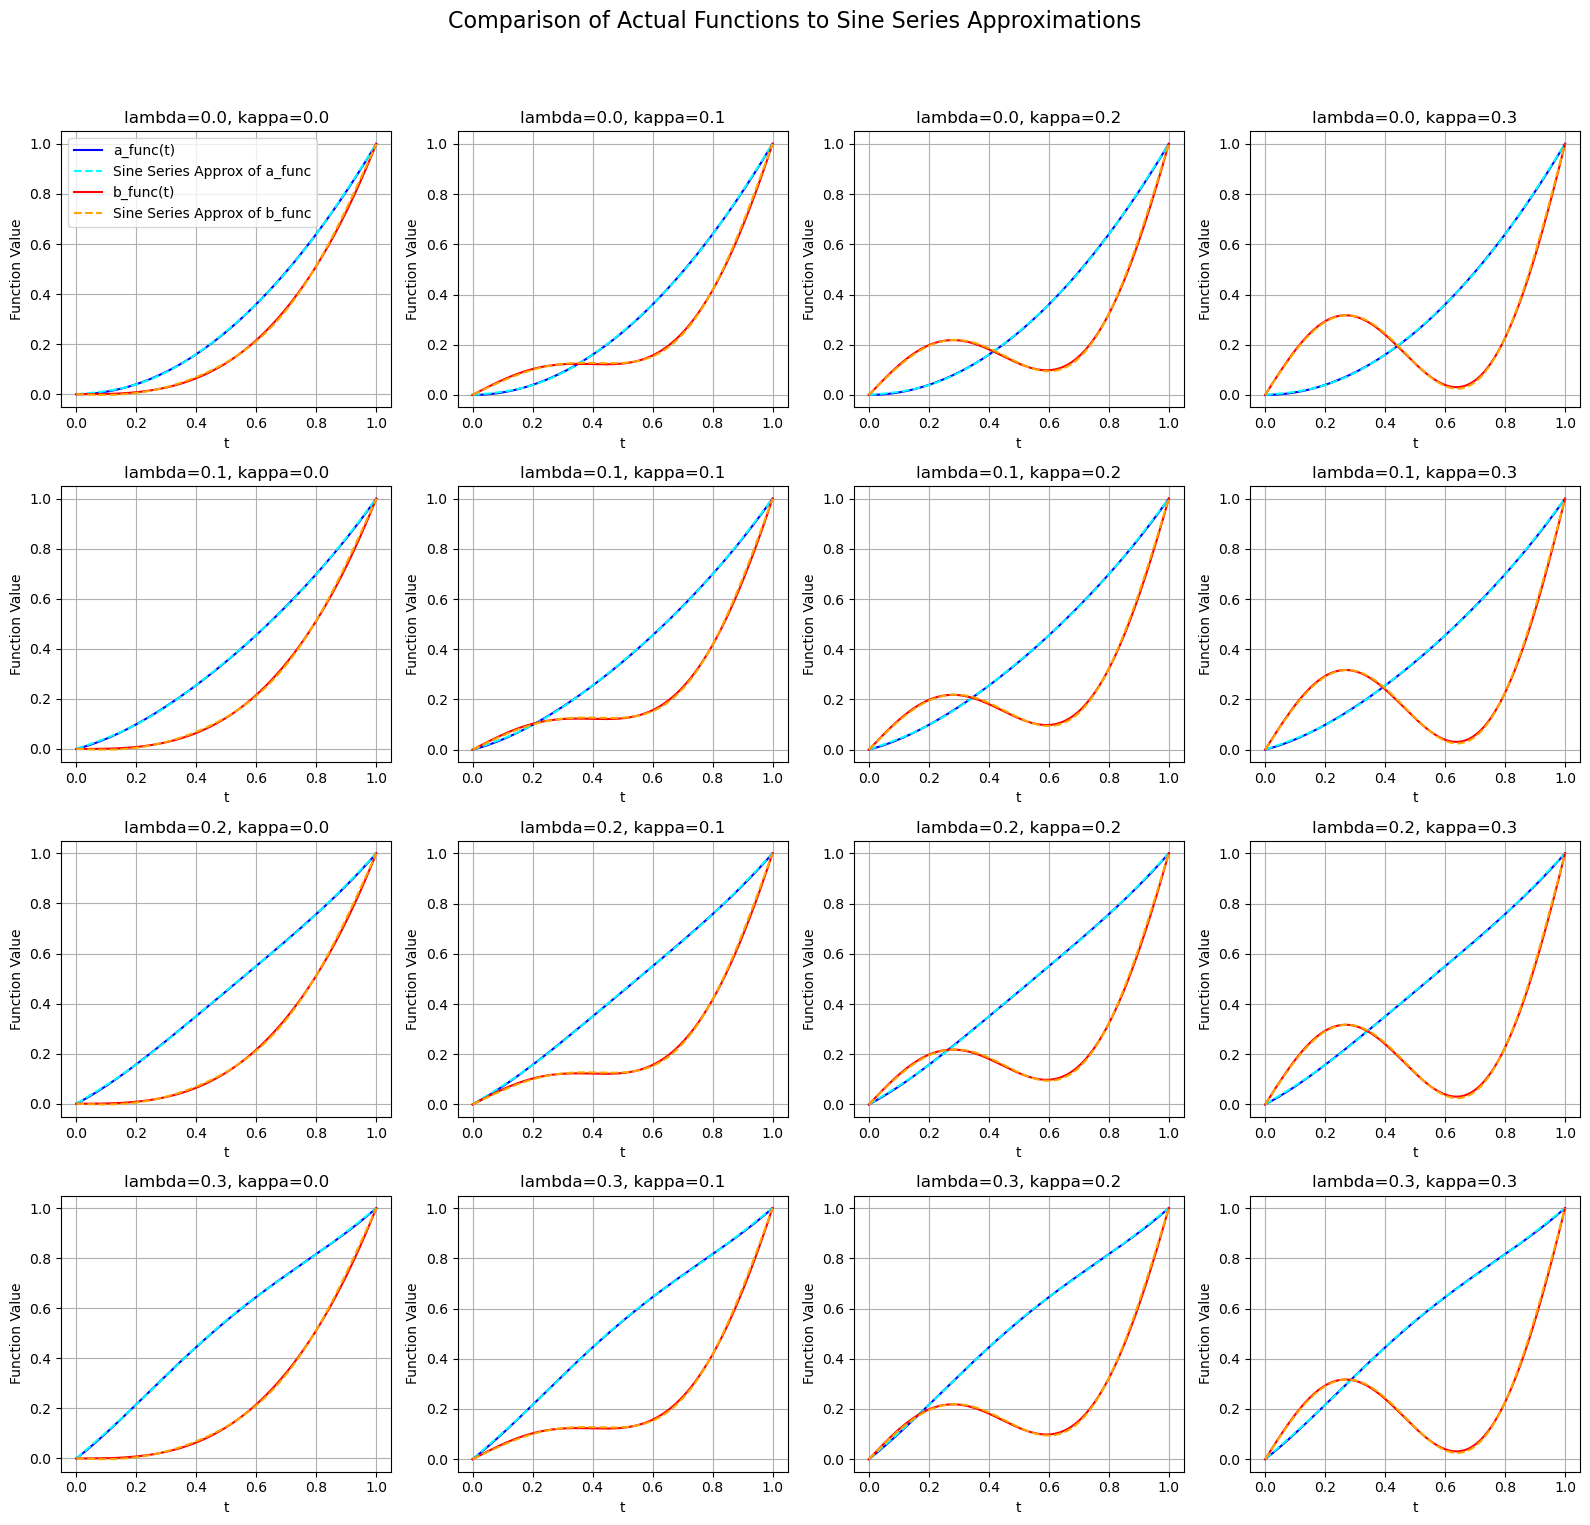

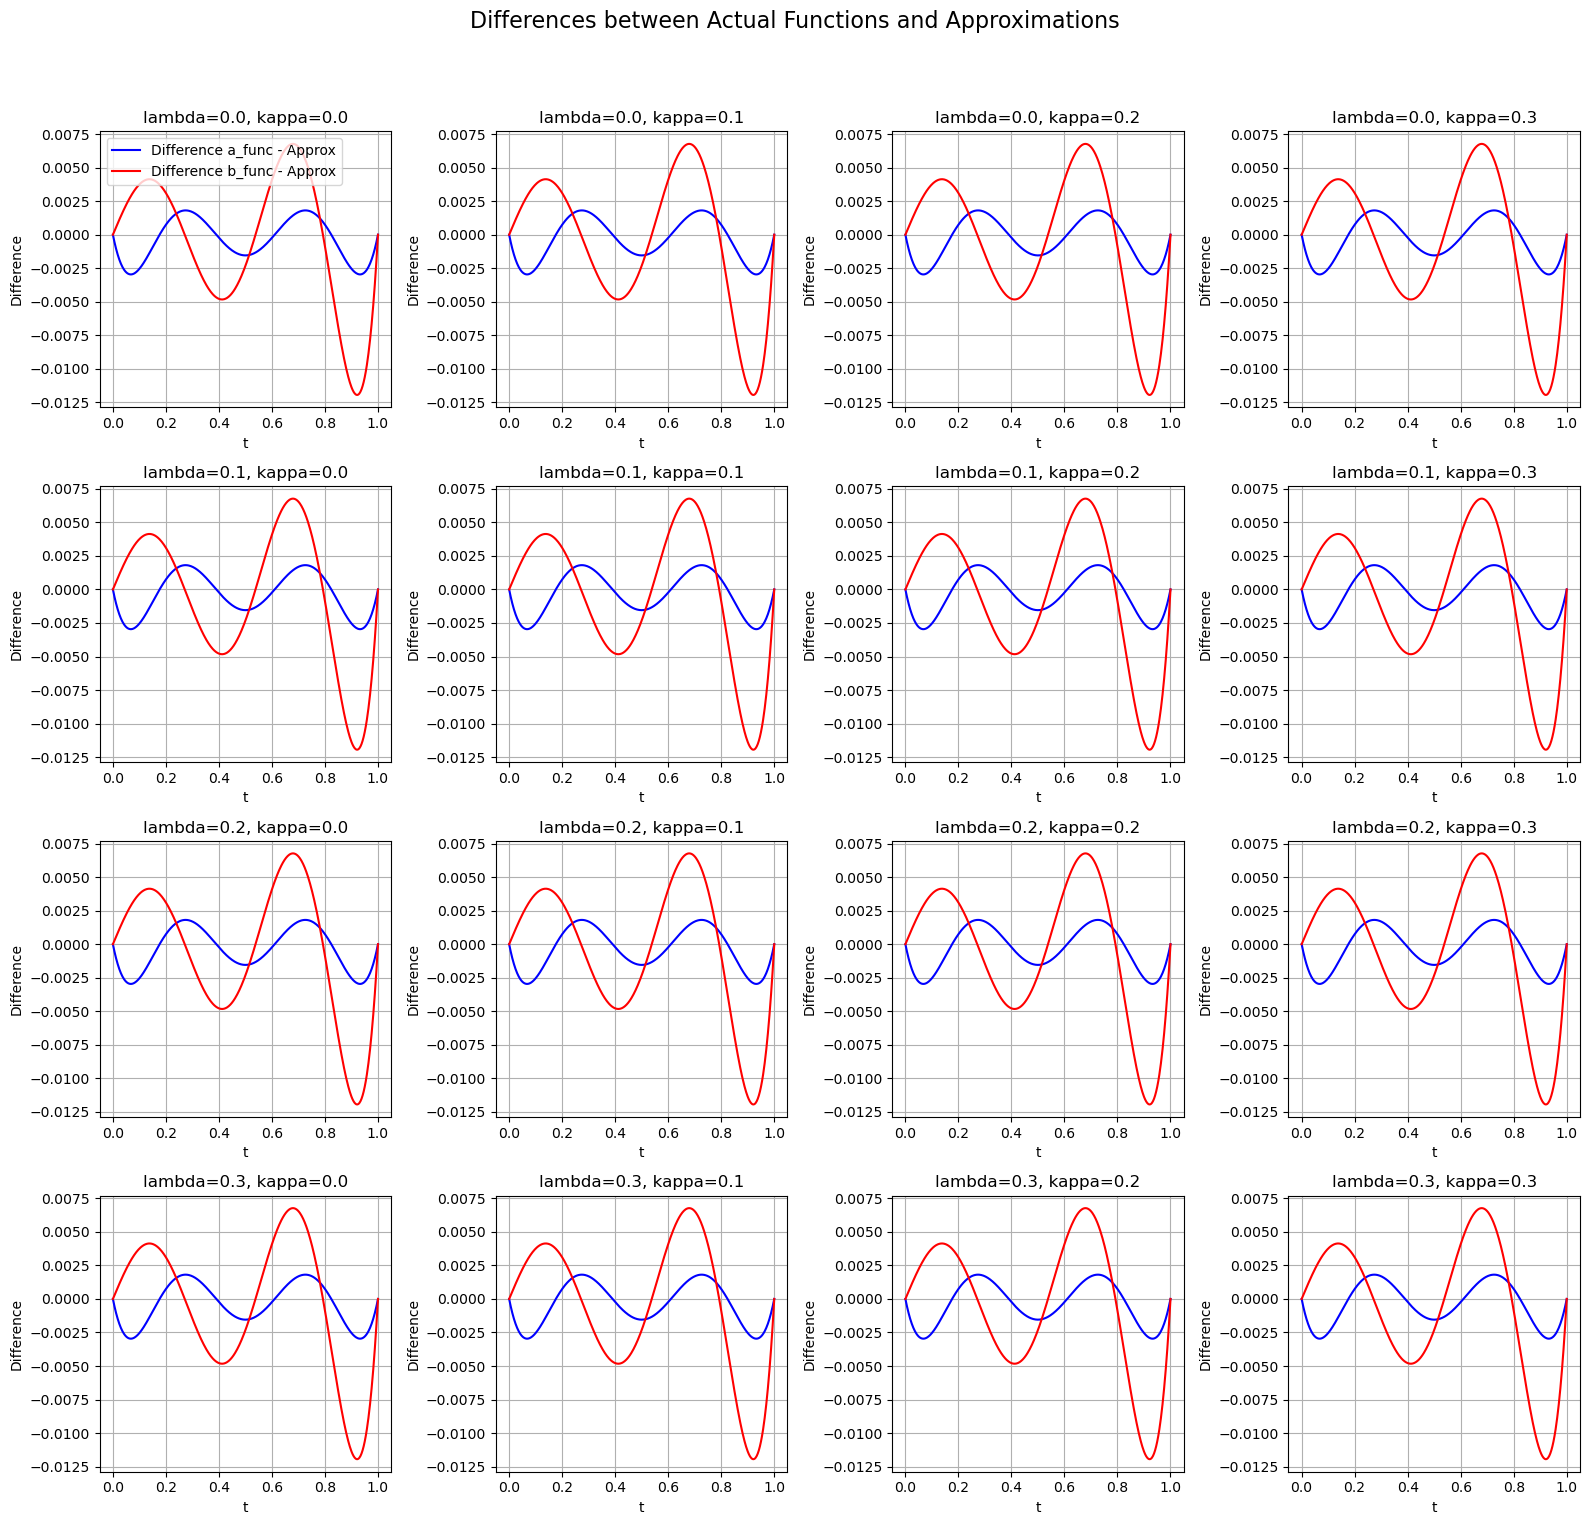

In [1236]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

def compute_sine_series_for_functions(a_func, b_func, lambd, kappa, N):
    """
    Compute the sine series coefficients a_n and b_n for functions a_func and b_func.
    
    Parameters:
    a_func: function(t, lambd, kappa)
        The function a_func(t, lambd, kappa) to be expanded.
    b_func: function(t, lambd, kappa)
        The function b_func(t, lambd, kappa) to be expanded.
    lambd: float
        Parameter lambda.
    kappa: float
        Parameter kappa.
    N: int
        Number of terms in the series.
    
    Returns:
    a_coeffs: numpy array
        The sine series coefficients for a_func.
    b_coeffs: numpy array
        The sine series coefficients for b_func.
    """
    pi = np.pi
    a_coeffs = np.zeros(N)
    b_coeffs = np.zeros(N)
    
    for n in range(1, N+1):
        # Compute coefficients for a_func
        def integrand_a(t):
            return 2 * (a_func(t, lambd, kappa) - t) * np.sin(n * pi * t)
        coeff_a, _ = quad(integrand_a, 0, 1)
        a_coeffs[n-1] = coeff_a
        
        # Compute coefficients for b_func
        def integrand_b(t):
            return 2 * (b_func(t, lambd, kappa) - t) * np.sin(n * pi * t)
        coeff_b, _ = quad(integrand_b, 0, 1)
        b_coeffs[n-1] = coeff_b
        
    return a_coeffs, b_coeffs

# Example functions that satisfy f(0) = 0 and f(1) = 1
def a_func(t, lambd, kappa):
    # Example function depending on lambda and kappa
    # Satisfies boundary conditions f(0) = 0, f(1) = 1
    return t**2 + lambd * np.sin(np.pi * t)

def b_func(t, lambd, kappa):
    # Another example function depending on lambda and kappa
    # Satisfies boundary conditions f(0) = 0, f(1) = 1
    return t**3 + kappa * np.sin(2 * np.pi * t)

def sine_series_approx(t, coeffs, N):
    n = np.arange(1, N+1)
    series_sum = np.sum(coeffs * np.sin(n * np.pi * t))
    return t + series_sum

# Parameters
N = 3  # Number of terms in the series
lambd_values = [0.0, 0.1, 0.2, 0.3]  # Different values of lambda
kappa_values = [0.0, 0.1, 0.2, 0.3]  # Different values of kappa

# Generate points for t
t_values = np.linspace(0, 1, 500)

# Create the first 4x4 grid of plots
fig1, axes1 = plt.subplots(4, 4, figsize=(16, 16))
fig1.suptitle('Comparison of Actual Functions to Sine Series Approximations', fontsize=16)

# Create the second 4x4 grid of plots for differences
fig2, axes2 = plt.subplots(4, 4, figsize=(16, 16))
fig2.suptitle('Differences between Actual Functions and Approximations', fontsize=16)

# Loop over lambda and kappa values
for i, lambd in enumerate(lambd_values):
    for j, kappa in enumerate(kappa_values):
        # Compute the sine series coefficients
        a_coeffs, b_coeffs = compute_sine_series_for_functions(a_func, b_func, lambd, kappa, N)
        
        # Compute original functions
        a_original = np.array([a_func(t, lambd, kappa) for t in t_values])
        b_original = np.array([b_func(t, lambd, kappa) for t in t_values])
        
        # Compute approximations using the sine series
        a_approx = np.array([sine_series_approx(t, a_coeffs, N) for t in t_values])
        b_approx = np.array([sine_series_approx(t, b_coeffs, N) for t in t_values])
        
        # Plotting the actual functions and their approximations
        ax1 = axes1[i, j]
        ax1.plot(t_values, a_original, label='a_func(t)', color='blue')
        ax1.plot(t_values, a_approx, '--', label='Sine Series Approx of a_func', color='cyan')
        ax1.plot(t_values, b_original, label='b_func(t)', color='red')
        ax1.plot(t_values, b_approx, '--', label='Sine Series Approx of b_func', color='orange')
        ax1.set_title(f'lambda={lambd}, kappa={kappa}')
        ax1.set_xlabel('t')
        ax1.set_ylabel('Function Value')
        if i == 0 and j == 0:
            ax1.legend(loc='upper left')
        ax1.grid(True)
        
        # Compute differences
        a_diff = a_original - a_approx
        b_diff = b_original - b_approx
        
        # Plotting the differences
        ax2 = axes2[i, j]
        ax2.plot(t_values, a_diff, label='Difference a_func - Approx', color='blue')
        ax2.plot(t_values, b_diff, label='Difference b_func - Approx', color='red')
        ax2.set_title(f'lambda={lambd}, kappa={kappa}')
        ax2.set_xlabel('t')
        ax2.set_ylabel('Difference')
        if i == 0 and j == 0:
            ax2.legend(loc='upper left')
        ax2.grid(True)

# Adjust layout for the first figure
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])

# Adjust layout for the second figure
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()
